<img src="logos/Picture1.png" alt="sd" style="width: 50%; height: auto;">

# Supplementary 5
**Species Distribution Modelling and Future Projections (Red Maple)**

Articule title

This section describes the complete workflow for modelling and projecting the distribution of Red Maple (_Acer rubrum_) across Québec under current and future climatic conditions. The analysis integrates large-scale ecoforestry data, soil and bioclimatic variables, and presence records to train a species distribution model using XGBoost. After filtering and spatially cleaning the provincial ecoforestry dataset with Dask, stands dominated by Red Maple (> 60 % composition) were selected and combined with environmental predictors. Pseudo-absences were generated within the Québec boundary while excluding 1 km buffers around presences. Bioclimatic and edaphic variables were extracted from pre-aligned raster layers and used to train and tune the model through Bayesian optimization (BayesSearchCV). The final model was transferred to multiple CMIP6 climate scenarios (e.g., HADGEM, IPSL, MIROC, NORESM, CMCC; RCP 4.5 and 8.5 for 2040–2060) to produce future probability maps of species presence. All spatial operations were conducted in EPSG:32198 for geometry processing and EPSG:4326 for raster sampling, ensuring full spatial consistency between present and projected environmental layers.

## Data loading and schema
Records were filtered to retain only stands where _Acer rubrum_ (Red Maple) was present at data/db_red_maple.csv.

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.ops import unary_union
from shapely.prepared import prep
import matplotlib.pyplot as plt
import os
import rioxarray as rxr

In [4]:


dred = pd.read_csv('data/db_red_maple.csv', dtype={'latitude': 'float64', 'longitude': 'float64'})

In [5]:
dred

,Unnamed: 0,essence,latitude,forest,longitude,elev,ph,clay,sand,bio1,...,bio15,bio18,bio20,bio23,bio24,bio27,bio30,bio31,bio34,cluster_k
0,577458,EO,47.761208,100,-73.022446,344,4.5000,85.0,85.0,1.765863,...,24.643180,301.000,19.051277,78.625160,588.10000,35.535050,-6.559094,9.199162,733.57570,1
1,1033211,EO,46.432621,100,-75.445401,239,5.1067,13.0,51.0,3.338708,...,12.093941,294.750,17.747839,75.759040,625.57500,33.815228,-1.487061,8.546481,798.44330,3
2,911397,EO,46.028920,100,-74.745012,285,5.5000,2.0,93.0,2.942621,...,12.358034,304.150,16.637333,82.134315,653.25000,33.674984,-4.342159,6.658854,784.00290,3
3,69869,EO,46.839032,100,-70.519246,363,3.5167,24.0,45.0,3.264520,...,17.166555,343.700,15.861320,91.072400,721.94995,32.355210,-5.601314,10.016439,715.82350,0
4,1521793,EO,48.080635,91,-79.398379,331,5.7000,90.0,0.0,0.868738,...,24.928170,261.750,20.987915,76.240395,541.90000,36.527588,-11.209414,9.943170,717.10360,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847957,772824,EO,45.995362,100,-74.002996,372,6.1000,69.0,4.0,4.209070,...,9.217865,285.925,17.601393,72.901840,636.12500,32.952133,-0.846002,3.312908,781.30550,3
847958,1073892,EO,46.137758,100,-75.599060,328,4.6167,4.0,81.0,3.904474,...,12.178079,280.350,19.275383,68.300415,591.17500,33.885113,-0.613117,7.181046,802.66705,3
847959,1336875,EO,46.359258,100,-77.158444,318,4.5000,85.0,85.0,3.932580,...,16.052400,237.125,23.497679,59.750330,521.40000,34.233120,-2.733226,9.741150,812.64520,1
847960,403313,EO,47.485293,100,-68.537980,362,4.8000,8.0,34.0,2.571893,...,15.102576,275.700,18.190674,79.534220,590.47500,32.157380,-2.661742,8.380980,732.18720,3


## Study Area Definition and Coordinate System

Administrative boundaries for Québec were extracted from the national shapefile lpr_000b21a_e.shp, provided by Statistics Canada.
Geometries were cleaned, validated, and reprojected from EPSG:3347 to EPSG:32198 (NAD83 / Québec Lambert).
This coordinate system was used for all geometric operations (buffers, random point generation, containment checks), while EPSG:4326 (WGS84) was used for raster sampling and final map outputs.

In [6]:
# 2. Crear GeoDataFrame de presencias
geometry = [Point(lon, lat) for lon, lat in zip(dred['longitude'], dred['latitude'])]
presences_gdf = gpd.GeoDataFrame(dred.copy(), geometry=geometry, crs="EPSG:4326")

In [7]:
# 4. Reproyectar
from pyproj import Transformer
from shapely.ops import transform

In [8]:
print("Reproyectando presencias...")
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32198", always_xy=True)
presences_proj_geom = presences_gdf.geometry.apply(lambda geom: transform(transformer.transform, geom))
presences_proj = gpd.GeoDataFrame(presences_gdf.drop(columns='geometry'), geometry=presences_proj_geom)
presences_proj.set_crs("EPSG:32198", allow_override=True, inplace=True)

Reproyectando presencias...


,Unnamed: 0,essence,latitude,forest,longitude,elev,ph,clay,sand,bio1,...,bio18,bio20,bio23,bio24,bio27,bio30,bio31,bio34,cluster_k,geometry
0,577458,EO,47.761208,100,-73.022446,344,4.5000,85.0,85.0,1.765863,...,301.000,19.051277,78.625160,588.10000,35.535050,-6.559094,9.199162,733.57570,1,POINT (-337745.54 428899.35)
1,1033211,EO,46.432621,100,-75.445401,239,5.1067,13.0,51.0,3.338708,...,294.750,17.747839,75.759040,625.57500,33.815228,-1.487061,8.546481,798.44330,3,POINT (-532511.46 296685.91)
2,911397,EO,46.028920,100,-74.745012,285,5.5000,2.0,93.0,2.942621,...,304.150,16.637333,82.134315,653.25000,33.674984,-4.342159,6.658854,784.00290,3,POINT (-482865.26 247053.66)
3,69869,EO,46.839032,100,-70.519246,363,3.5167,24.0,45.0,3.264520,...,343.700,15.861320,91.072400,721.94995,32.355210,-5.601314,10.016439,715.82350,0,POINT (-153767.5 318115.51)
4,1521793,EO,48.080635,91,-79.398379,331,5.7000,90.0,0.0,0.868738,...,261.750,20.987915,76.240395,541.90000,36.527588,-11.209414,9.943170,717.10360,1,POINT (-805940.7 515109.13)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847957,772824,EO,45.995362,100,-74.002996,372,6.1000,69.0,4.0,4.209070,...,285.925,17.601393,72.901840,636.12500,32.952133,-0.846002,3.312908,781.30550,3,POINT (-425899.81 238624.65)
847958,1073892,EO,46.137758,100,-75.599060,328,4.6167,4.0,81.0,3.904474,...,280.350,19.275383,68.300415,591.17500,33.885113,-0.613117,7.181046,802.66705,3,POINT (-547498.74 265245.62)
847959,1336875,EO,46.359258,100,-77.158444,318,4.5000,85.0,85.0,3.932580,...,237.125,23.497679,59.750330,521.40000,34.233120,-2.733226,9.741150,812.64520,1,POINT (-664258.1 302910.31)
847960,403313,EO,47.485293,100,-68.537980,362,4.8000,8.0,34.0,2.571893,...,275.700,18.190674,79.534220,590.47500,32.157380,-2.661742,8.380980,732.18720,3,POINT (-2854.52 387637.46)


## Pseudo-absence Generation

To create pseudo-absences unbiased by proximity to presences, we implemented the following steps:

1. Created 1 km exclusion buffers around each presence point.
2. Uniformly sampled random candidate points across the Québec bounding box.
3. Retained points inside Québec and outside the exclusion buffer, until 40,000 valid pseudo-absences were obtained.

Pseudo-absence points were saved as data/pseudoausencias_quebec.geojson (projected) and data/pseudoausencias_latlon_sugarmaple.csv (geographic).

In [9]:
# 1. Cargar provincias de Canadá
print("Cargando shapefile...")
provincias = gpd.read_file("data/Politic_divition/lpr_000b21a_e.shp")
print(f"CRS detectado: {provincias.crs}")

# 2. Filtrar sólo Québec
print("Filtrando Québec...")
quebec_map = provincias[provincias['PRENAME'] == 'Quebec'].copy()

# 3. Limpiar geometrías
print("Limpiando geometrías...")
quebec_map = quebec_map[quebec_map.geometry.notnull()]
quebec_map = quebec_map[~quebec_map.geometry.is_empty]
quebec_map = quebec_map[quebec_map.is_valid]

# 4. Reproyectar de EPSG:3347 a EPSG:32198
print("Reproyectando Québec a EPSG:32198...")
quebec_proj = quebec_map.to_crs("EPSG:32198")

# 5. Verificar límites
print("Calculando límites...")
minx, miny, maxx, maxy = quebec_proj.total_bounds
print(f"Límites: minx={minx}, miny={miny}, maxx={maxx}, maxy={maxy}")

Cargando shapefile...
CRS detectado: EPSG:3347
Filtrando Québec...
Limpiando geometrías...
Reproyectando Québec a EPSG:32198...
Calculando límites...
Límites: minx=-830844.1785054514, miny=117973.29776183645, maxx=783631.6436369262, maxy=2091048.2097644005


In [10]:
print("Generando zona de exclusión...")
buffer_m = 1000  # Buffer de 1000 metros
exclusion_zone = presences_proj.buffer(buffer_m)
exclusion_union = unary_union(exclusion_zone)
exclusion_prepared = prep(exclusion_union)

Generando zona de exclusión...


In [11]:
print("Calculando límites de Québec...")
minx, miny, maxx, maxy = quebec_proj.total_bounds

Calculando límites de Québec...


In [12]:
print("Generando puntos candidatos...")
n_desired = 40000  # Número de pseudoausencias que quieres
batch_multiplier = 5  # Generar más para filtrar después

x_coords = np.random.uniform(minx, maxx, n_desired * batch_multiplier)
y_coords = np.random.uniform(miny, maxy, n_desired * batch_multiplier)
candidate_points = [Point(x, y) for x, y in zip(x_coords, y_coords)]

Generando puntos candidatos...


In [13]:
# 9. Filtrar puntos: dentro de Québec y fuera del buffer
quebec_union = quebec_proj.unary_union
quebec_prepared = prep(quebec_union)

valid_points = []
for pt in candidate_points:
    if quebec_prepared.contains(pt) and not exclusion_prepared.contains(pt):
        valid_points.append(pt)
        if len(valid_points) >= n_desired:
            break

print(f"Total pseudoausencias generadas: {len(valid_points)}")

C:\Users\jorge\AppData\Local\Temp\ipykernel_15400\3944305408.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  quebec_union = quebec_proj.unary_union


Total pseudoausencias generadas: 40000


In [15]:
# 10. Crear GeoDataFrame de pseudoausencias
pseudo_gdf = gpd.GeoDataFrame(geometry=valid_points, crs="EPSG:32198")

# 11. Guardar a GeoJSON
print("Guardando pseudoausencias en archivo...")
pseudo_gdf.to_file("data/pseudoausencias_quebec_red.geojson", driver="GeoJSON")

Guardando pseudoausencias en archivo...


Graficando...


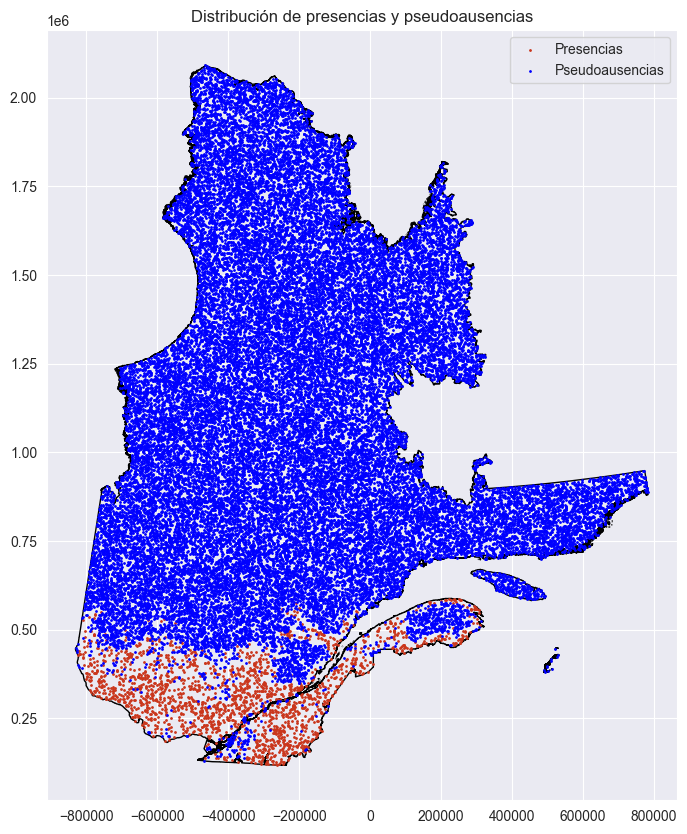

In [17]:
print("Graficando...")
ax = quebec_proj.plot(color='none', edgecolor='black', figsize=(10, 10))
presences_proj.sample(2000).plot(ax=ax, color='#ca361c', markersize=1, label="Presencias")
pseudo_gdf.plot(ax=ax, color='blue', markersize=1, label="Pseudoausencias")
plt.legend()
plt.title("Distribución de presencias y pseudoausencias")
plt.show()

In [18]:
pseudo_gdf = gpd.GeoDataFrame(geometry=valid_points, crs="EPSG:32198")

# 11. Reproyectar de regreso a EPSG:4326 (latitud-longitud)
pseudo_gdf_latlon = pseudo_gdf.to_crs("EPSG:4326")

# 12. Extraer columnas de latitud y longitud
pseudo_gdf_latlon['longitude'] = pseudo_gdf_latlon.geometry.x
pseudo_gdf_latlon['latitude'] = pseudo_gdf_latlon.geometry.y

# 13. Crear un DataFrame plano si quieres
pseudo_df = pseudo_gdf_latlon[['latitude', 'longitude']].copy()

# 14. Guardar como CSV
pseudo_df.to_csv("data/pseudoausencias_latlon_redmaple.csv", index=False)

In [20]:
dredm = dred.drop(columns=['elev'])
pseured = pseudo_df.copy()

We assembled 21 environmental predictors representing edaphic and bioclimatic gradients from pre-aligned rasters located in bioclim_data/recortados_alineados.
These include soil variables (ph, clay, sand) and WorldClim-derived bioclimatic indices.
Values were extracted for both presence and pseudo-absence points using rioxarray, applying nearest-neighbour sampling while ensuring CRS consistency (EPSG:4326).
Presences were labeled as 1 and pseudo-absences as 0, forming a final training dataset (data/dataset_distribucion_xgboost_red.csv).

In [21]:
print(dredm.columns)

Index(['Unnamed: 0', 'essence', 'latitude', 'forest', 'longitude', 'ph',
       'clay', 'sand', 'bio1', 'bio2', 'bio3', 'bio8', 'bio9', 'bio10',
       'bio11', 'bio12', 'bio14', 'bio15', 'bio18', 'bio20', 'bio23', 'bio24',
       'bio27', 'bio30', 'bio31', 'bio34', 'cluster_k'],
      dtype='object')


In [22]:
ruta_rasters = "bioclim_data/recortados_alineados"
#dredm
variables = [
'ph', 'clay', 'sand', 'bio1', 'bio2', 'bio3', 'bio8', 'bio9', 'bio10',
'bio11', 'bio12', 'bio14', 'bio15', 'bio18', 'bio20', 'bio23', 'bio24',
'bio27', 'bio30', 'bio31', 'bio34'
]

In [23]:
geometry = [Point(lon, lat) for lon, lat in zip(pseured['longitude'], pseured['latitude'])]
pseudo_gdf = gpd.GeoDataFrame(pseured.copy(), geometry=geometry, crs="EPSG:4326")

# 5. Crear columnas vacías para las variables
for var in variables:
    pseured[var] = np.nan

In [24]:
for var in variables:
    print(f"Extrayendo valores de {var}.tif...")
    ruta_raster = os.path.join(ruta_rasters, f"{var}.tif")
    raster = rxr.open_rasterio(ruta_raster, masked=True).squeeze()  # quitar dimensión de banda

    # Asegurar CRS
    if raster.rio.crs is None:
        raster = raster.rio.write_crs("EPSG:4326")

    # Reproyectar puntos si es necesario
    if pseudo_gdf.crs != raster.rio.crs:
        pseudo_gdf = pseudo_gdf.to_crs(raster.rio.crs)

    # Extraer valores
    pseudo_gdf[var] = [float(raster.sel(x=pt.x, y=pt.y, method="nearest").values) for pt in pseudo_gdf.geometry]

Extrayendo valores de ph.tif...
Extrayendo valores de clay.tif...
Extrayendo valores de sand.tif...
Extrayendo valores de bio1.tif...
Extrayendo valores de bio2.tif...
Extrayendo valores de bio3.tif...
Extrayendo valores de bio8.tif...
Extrayendo valores de bio9.tif...
Extrayendo valores de bio10.tif...
Extrayendo valores de bio11.tif...
Extrayendo valores de bio12.tif...
Extrayendo valores de bio14.tif...
Extrayendo valores de bio15.tif...
Extrayendo valores de bio18.tif...
Extrayendo valores de bio20.tif...
Extrayendo valores de bio23.tif...
Extrayendo valores de bio24.tif...
Extrayendo valores de bio27.tif...
Extrayendo valores de bio30.tif...
Extrayendo valores de bio31.tif...
Extrayendo valores de bio34.tif...


In [26]:
pseudo_gdf['presencia'] = 0  # 0 para pseudoausencias
pseudo_gdf

,latitude,longitude,geometry,ph,clay,sand,bio1,bio2,bio3,bio8,...,bio15,bio18,bio20,bio23,bio24,bio27,bio30,bio31,bio34,presencia
0,48.561392,-72.412475,POINT (-72.41248 48.56139),5.3733,22.0,35.0,1.402490,11.046304,23.107239,11.420785,...,26.180964,282.625000,20.297527,75.268890,559.400024,36.355186,-6.909330,11.282836,698.695923,0
1,50.273321,-70.359605,POINT (-70.35961 50.27332),4.5000,85.0,85.0,-1.551855,11.112822,23.107296,10.019485,...,33.907505,335.325012,16.251116,102.983009,573.199951,36.271683,-11.538630,10.540295,602.154419,0
2,48.281032,-78.127005,POINT (-78.12701 48.28103),5.3900,70.0,0.0,0.806970,11.936042,24.295807,13.361871,...,29.492531,303.750000,19.146954,85.878212,601.275024,36.471848,-10.258423,12.558605,709.791138,0
3,53.025472,-77.293503,POINT (-77.2935 53.02547),0.0000,0.0,85.0,-3.005072,10.622674,21.573875,6.551061,...,44.306747,214.899994,20.790253,85.831291,430.475006,37.216106,-15.941702,5.715313,545.709045,0
4,55.079560,-74.132811,POINT (-74.13281 55.07956),5.1000,41.0,73.0,-5.317481,9.123371,19.701096,6.418522,...,44.944580,261.250000,15.371072,117.890472,415.125000,36.522900,-18.637815,6.740541,410.607086,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53.008060,-69.510915,POINT (-69.51091 53.00806),4.5000,85.0,85.0,-4.036170,9.694582,20.363941,9.107080,...,39.046711,307.049988,16.340225,104.912666,467.600006,37.803509,-15.402933,7.579696,467.973633,0
39996,55.258859,-67.429827,POINT (-67.42983 55.25886),7.6000,43.0,43.0,-5.472723,9.353113,19.851831,2.345990,...,25.022282,254.175003,16.069233,103.575615,383.799988,37.631672,-13.607791,1.101681,423.291443,0
39997,58.356766,-72.029850,POINT (-72.02985 58.35677),7.6000,43.0,43.0,-6.821509,7.966253,18.034559,-2.140275,...,28.483028,165.699997,18.247026,79.271904,217.625000,35.463539,-13.341063,-1.495312,332.634766,0
39998,58.380624,-69.024709,POINT (-69.02471 58.38062),7.6000,43.0,43.0,-6.426886,8.586772,18.892845,-0.762638,...,26.186684,173.824997,18.328564,76.474327,229.549988,35.961823,-12.193865,-1.454055,367.651611,0


In [27]:
dredm['presencia'] = 1  # 1 para presencias

In [28]:
# Seleccionar columnas comunes
columnas_finales = variables + ['presencia', 'latitude', 'longitude']
dredm = dredm[columnas_finales]
pseudo_final = pseudo_gdf[columnas_finales]

dataset_final = pd.concat([dredm, pseudo_final], ignore_index=True)

print("Dataset final creado con shape:", dataset_final.shape)

# 12. Guardar dataset listo para modelar
dataset_final.to_csv("data/dataset_distribucion_xgboost_red.csv", index=False)

Dataset final creado con shape: (887962, 24)


In [29]:
dataset_final

,ph,clay,sand,bio1,bio2,bio3,bio8,bio9,bio10,bio11,...,bio20,bio23,bio24,bio27,bio30,bio31,bio34,presencia,latitude,longitude
0,4.5000,85.0,85.0,1.765863,11.665550,24.627048,10.083366,-4.941776,16.269623,-14.851273,...,19.051277,78.625160,588.100000,35.535050,-6.559094,9.199162,733.575700,1,47.761208,-73.022446
1,5.1067,13.0,51.0,3.338708,12.062305,26.139599,6.406872,0.535689,17.004885,-12.422948,...,17.747839,75.759040,625.575000,33.815228,-1.487061,8.546481,798.443300,1,46.432621,-75.445401
2,5.5000,2.0,93.0,2.942621,12.043652,26.202797,6.265319,-0.750032,16.505472,-12.801185,...,16.637333,82.134315,653.250000,33.674984,-4.342159,6.658854,784.002900,1,46.028920,-74.745012
3,3.5167,24.0,45.0,3.264520,9.833704,23.110264,10.753249,-3.768932,16.660534,-11.466643,...,15.861320,91.072400,721.949950,32.355210,-5.601314,10.016439,715.823500,1,46.839032,-70.519246
4,5.7000,90.0,0.0,0.868738,12.094368,24.407988,12.386785,-11.125838,15.516946,-16.398120,...,20.987915,76.240395,541.900000,36.527588,-11.209414,9.943170,717.103600,1,48.080635,-79.398379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887957,4.5000,85.0,85.0,-4.036170,9.694582,20.363941,9.107080,-15.678899,11.917279,-21.484013,...,16.340225,104.912666,467.600006,37.803509,-15.402933,7.579696,467.973633,0,53.008060,-69.510915
887958,7.6000,43.0,43.0,-5.472723,9.353113,19.851831,2.345990,-15.202168,10.358541,-22.564262,...,16.069233,103.575615,383.799988,37.631672,-13.607791,1.101681,423.291443,0,55.258859,-67.429827
887959,7.6000,43.0,43.0,-6.821509,7.966253,18.034559,-2.140275,-13.289006,7.807535,-23.370964,...,18.247026,79.271904,217.625000,35.463539,-13.341063,-1.495312,332.634766,0,58.356766,-72.029850
887960,7.6000,43.0,43.0,-6.426886,8.586772,18.892845,-0.762638,-12.989489,8.491302,-22.980452,...,18.328564,76.474327,229.549988,35.961823,-12.193865,-1.454055,367.651611,0,58.380624,-69.024709


## Model Training and Hyperparameter Optimization

We trained an XGBoost binary classifier (objective='binary:logistic', eval_metric='logloss') to estimate the probability of species presence.
Data were split into training (80 %) and testing (20 %) subsets with stratification by presence label.
Hyperparameter tuning was performed using Bayesian optimization (BayesSearchCV, 50 iterations, 3-fold cross-validation, roc_auc scoring).

In [30]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
print("Eliminando duplicados lat/lon...")
dataset_final = dataset_final.drop_duplicates(subset=['latitude', 'longitude'])

Eliminando duplicados lat/lon...


In [32]:
print("Shape final después de limpieza:", dataset_final.shape)

Shape final después de limpieza: (887962, 24)


In [33]:
X = dataset_final[['ph', 'clay', 'sand', 'bio1', 'bio2', 'bio3', 'bio8', 'bio9', 'bio10',
'bio11', 'bio12', 'bio14', 'bio15', 'bio18', 'bio20', 'bio23', 'bio24',
'bio27', 'bio30', 'bio31', 'bio34']]

In [34]:
y = dataset_final['presencia']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [36]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [43]:
modelo = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    #use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

In [44]:
param_space = {
    'n_estimators': Integer(100, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 12),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'gamma': Real(0, 5),
    'reg_alpha': Real(0, 1),
    'reg_lambda': Real(0, 1)
}

In [45]:
opt = BayesSearchCV(
    estimator=modelo,
    search_spaces=param_space,
    n_iter=50,  # Número de combinaciones a probar
    scoring='roc_auc',  # M distribución de especies
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [46]:
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

,estimator,"XGBClassifier...ree=None, ...)"
,search_spaces,"{'colsample_bytree': Real(low=0.5,...m='normalize'), 'gamma': Real(low=0, h...m='normalize'), 'learning_rate': Real(low=0.01...m='normalize'), 'max_depth': Integer(low=3...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,50
,scoring,'roc_auc'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [47]:
print("Mejores hiperparámetros encontrados:")
print(opt.best_params_)

Mejores hiperparámetros encontrados:
OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0), ('learning_rate', 0.29999999999999993), ('max_depth', 12), ('n_estimators', 100), ('reg_alpha', 0.2697531563624628), ('reg_lambda', 0.9313871305861529), ('subsample', 0.8287391527285375)])


In [48]:
# 8. Evaluar el modelo encontrado
best_model = opt.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_proba)
print(f"AUC con mejores parámetros: {auc:.3f}")

AUC con mejores parámetros: 0.998


In [60]:
import xarray as xr
import rioxarray as rxr

Based on the results we modelling with those

## Spatial Prediction Under Current Conditions

To map the probability of Red Maple presence, we concatenated all environmental layers into a 21-band stack using xarray, ordered consistently with the model’s input features.
The stack was reshaped into a 2D array of pixel observations and passed through the trained model to obtain per-pixel probabilities (predict_proba[:, 1]).
Predictions were reshaped to raster format and exported as probabilidad_redmaple.tif using the original georeferencing and transform.

In [50]:
# 1. Entrenar modelo final
modelo_final = XGBClassifier(
    colsample_bytree=1.0,
    gamma=0.0,
    learning_rate=0.29999999999999993,
    max_depth=12,
    n_estimators=100,
    reg_alpha=0.2697531563624628,
    reg_lambda=0.9313871305861529,
    subsample=0.8287391527285375,
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)
modelo_final.fit(X, y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [57]:
ruta_rasters = "bioclim_data/recortados_alineados"

# Lista exacta de variables que usaste en X
variables = [
'ph', 'clay', 'sand', 'bio1', 'bio2', 'bio3', 'bio8', 'bio9', 'bio10',
'bio11', 'bio12', 'bio14', 'bio15', 'bio18', 'bio20', 'bio23', 'bio24',
'bio27', 'bio30', 'bio31', 'bio34'
]

In [58]:
data_vars = []
for var in variables:
    path = os.path.join(ruta_rasters, f"{var}.tif")
    da = rxr.open_rasterio(path, masked=True).squeeze()  # .squeeze() para quitar dimensiones extras
    data_vars.append(da)


In [61]:
stack = xr.concat(data_vars, dim="band")
stack = stack.transpose("y", "x", "band")

In [62]:
grid = stack.values  # (rows, cols, bands)
n_rows, n_cols, n_vars = grid.shape
X_grid = grid.reshape((n_rows * n_cols, n_vars))

In [63]:
y_pred_proba = modelo_final.predict_proba(X_grid)[:, 1]

# 3.2 Volver a formato de imagen
proba_map = y_pred_proba.reshape((n_rows, n_cols))

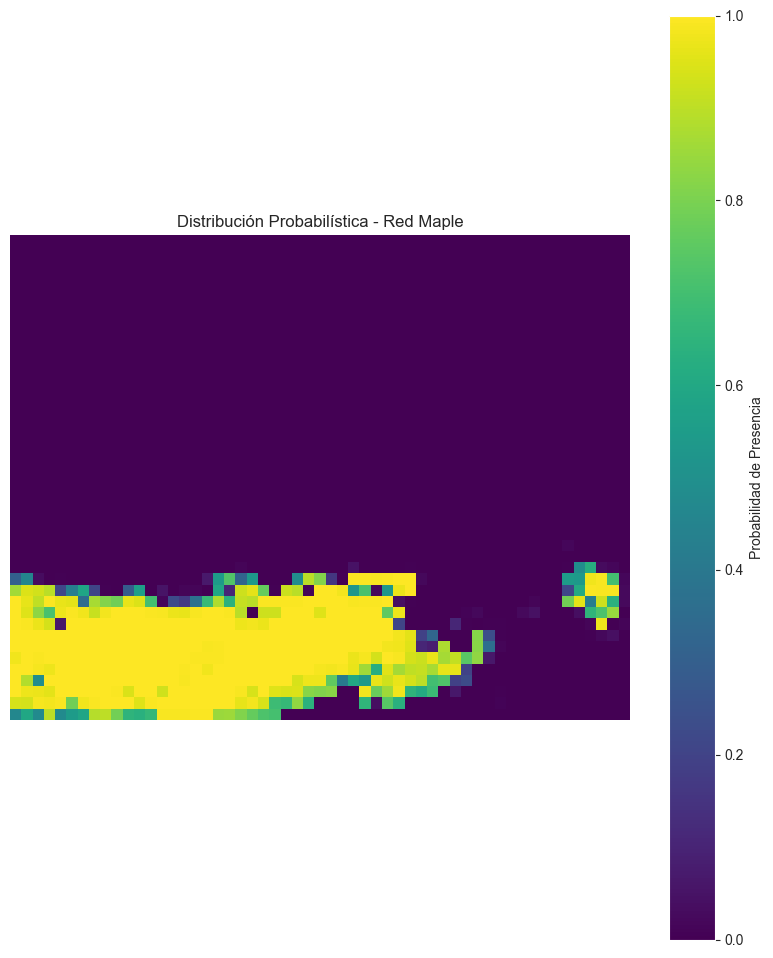

In [64]:
plt.figure(figsize=(10, 12))
im = plt.imshow(proba_map, cmap="viridis", vmin=0, vmax=1)
plt.colorbar(im, label="Probabilidad de Presencia")
plt.title("Distribución Probabilística - Red Maple")
plt.axis("off")
plt.show()

## Projection to Future Climate Scenarios

We extended the trained model to future climate scenarios (2040–2060) from five CMIP6 general circulation models (GCMs) and two RCP pathways (4.5 and 8.5).
Future rasters were clipped to Québec and stored in futuros_clip. Static layers (ph, clay, sand) were reused from the present dataset. Before modeling, all rasters were checked for consistent extent, resolution, CRS, and band order.
Points falling outside the Québec polygon or over no-data cells were excluded.
Model predictions were visually inspected for continuity and absence of striping artefacts.

In [67]:
import rasterio
from rasterio.transform import from_origin
from tqdm import tqdm
from joblib import load
import pickle
from joblib import dump

In [66]:
transform = stack.rio.transform()
crs = stack.rio.crs

# Guardar como nuevo raster
with rasterio.open(
    "probabilidad_redmaple.tif",
    "w",
    driver="GTiff",
    height=proba_map.shape[0],
    width=proba_map.shape[1],
    count=1,
    dtype=proba_map.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(proba_map, 1)

In [68]:
#modelo_path = "modelo/modelo_redmaple.pkl"
#os.makedirs(os.path.dirname(modelo_path), exist_ok=True)
#dump(modelo_final, modelo_path)

['modelo/modelo_redmaple.pkl']

In [69]:
modelo_final = load("modelo/modelo_redmaple.pkl")
print("✅ Modelo cargado exitosamente")

✅ Modelo cargado exitosamente


In [70]:
dir_futuro = r"futuros_clip"

# Variables que espera el modelo
variables = [
'ph', 'clay', 'sand', 'bio1', 'bio2', 'bio3', 'bio8', 'bio9', 'bio10',
'bio11', 'bio12', 'bio14', 'bio15', 'bio18', 'bio20', 'bio23', 'bio24',
'bio27', 'bio30', 'bio31', 'bio34'
]

In [71]:
# Variables que son estáticas (no dependen del escenario futuro)
variables_estaticas = ['clay', 'sand', 'ph']

In [72]:
# Ruta a los rasters estáticos
dir_estaticos = r"bioclim_data\\recortados_alineados"

# Cargar modelo entrenado
with open('modelo/modelo_redmaple.pkl', 'rb') as f:
    modelo_final = pickle.load(f)

In [73]:
escenarios_validos = [
    "CMCC_85_2040_79", "CMCC_85_2060_99",
    "HADGEM_45_2040_79", "HADGEM_45_2060_99",
    "HADGEM_85_2040_79", "HADGEM_85_2060_99",
    "IPSL_45_2040_79", "IPSL_45_2060_99",
    "IPSL_85_2040_79", "IPSL_85_2060_99",
    "MIROC_45_2040_79", "MIROC_45_2060_99",
    "MIROC_85_2040_79", "MIROC_85_2060_99",
    "NORESM_45_2040_79", "NORESM_45_2060_99",
    "NORESM_85_2040_79", "NORESM_85_2060_99"
]

In [75]:
# Carpeta para guardar las predicciones
out_dir = r"futuro_predicho_red"
os.makedirs(out_dir, exist_ok=True)

In [76]:
for escenario in escenarios_validos:
    print(f"🛰️ Proyectando escenario: {escenario}...")
    try:
        data_vars = []

        for var in variables:
            if var in variables_estaticas:
                raster_path = os.path.join(dir_estaticos, f"{var}.tif")
            else:
                pattern = f"{var.upper()}_{escenario}.tif"
                matches = [f for f in os.listdir(dir_futuro) if f == pattern]
                if not matches:
                    raise FileNotFoundError(f"No se encontró el archivo para la variable {var} y escenario {escenario}")
                raster_path = os.path.join(dir_futuro, matches[0])

            da = rxr.open_rasterio(raster_path, masked=True).squeeze()
            data_vars.append(da)

        # Crear stack
        stack = xr.concat(data_vars, dim="band").transpose("y", "x", "band")

        # Preparar datos para predicción
        grid = stack.values
        n_rows, n_cols, n_vars = grid.shape
        X_grid = grid.reshape((n_rows * n_cols, n_vars))

        # Predicción
        y_pred_proba = modelo_final.predict_proba(X_grid)[:, 1]
        proba_map = y_pred_proba.reshape((n_rows, n_cols))

        # Guardar el raster de predicción
        transform = stack.rio.transform()
        crs = stack.rio.crs

        output_path = os.path.join(out_dir, f"prediccion_{escenario}.tif")
        import rasterio
        with rasterio.open(
            output_path, "w",
            driver="GTiff",
            height=proba_map.shape[0],
            width=proba_map.shape[1],
            count=1,
            dtype=proba_map.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(proba_map, 1)

        print(f"✅ Predicción guardada: {output_path}")

    except Exception as e:
        print(f"❌ Error en {escenario}: {e}")

🛰️ Proyectando escenario: CMCC_85_2040_79...
❌ Error en CMCC_85_2040_79: No se encontró el archivo para la variable bio18 y escenario CMCC_85_2040_79
🛰️ Proyectando escenario: CMCC_85_2060_99...
✅ Predicción guardada: futuro_predicho_red\prediccion_CMCC_85_2060_99.tif
🛰️ Proyectando escenario: HADGEM_45_2040_79...
✅ Predicción guardada: futuro_predicho_red\prediccion_HADGEM_45_2040_79.tif
🛰️ Proyectando escenario: HADGEM_45_2060_99...
✅ Predicción guardada: futuro_predicho_red\prediccion_HADGEM_45_2060_99.tif
🛰️ Proyectando escenario: HADGEM_85_2040_79...
✅ Predicción guardada: futuro_predicho_red\prediccion_HADGEM_85_2040_79.tif
🛰️ Proyectando escenario: HADGEM_85_2060_99...
❌ Error en HADGEM_85_2060_99: No se encontró el archivo para la variable bio18 y escenario HADGEM_85_2060_99
🛰️ Proyectando escenario: IPSL_45_2040_79...
✅ Predicción guardada: futuro_predicho_red\prediccion_IPSL_45_2040_79.tif
🛰️ Proyectando escenario: IPSL_45_2060_99...
✅ Predicción guardada: futuro_predicho_red